In [1]:
print("Hello, Colab!")

Hello, Colab!


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np

# For splitting data and scaling
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
import matplotlib.pyplot as plt
import seaborn as sns

# For balancing data classes
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Logistic Regression model and evaluation metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, classification_report
from sklearn.feature_selection import RFE



In [4]:
# Load the dataset
file_path = '/content/drive/My Drive/nlp/dataset_final/daily_news/qqq/QQQ_numerical.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataset
print(data.head())


        Price    Open   Close    High      Volume
0      Ticker     QQQ     QQQ     QQQ         QQQ
1        Date     NaN     NaN     NaN         NaN
2  2020-06-09  233.28  235.84  236.69  35046300.0
3  2020-06-08   232.2  234.14  234.27  32937300.0
4  2020-06-05  228.98  232.34  232.93  47365600.0


In [5]:
# Check for missing values
print(data.isnull().sum())

# Summary statistics of the dataset
print(data.describe())


Price     0
Open      1
Close     1
High      1
Volume    1
dtype: int64
             Price    Open  Close   High      Volume
count         2326    2325   2325   2325        2325
unique        2326    2091   2083   2091        2323
top     2011-03-16  101.63  60.94  62.01  20499400.0
freq             1       4      4      4           2


In [6]:
import pandas as pd

# Step 1: Skip the first two junk rows and create a clean copy
data_cleaned = data.iloc[2:].copy()

# Step 2: Rename the 'Price' column to 'Date'
data_cleaned.rename(columns={'Price': 'Date'}, inplace=True)

# Step 3: Convert the 'Date' column to a proper datetime format
data_cleaned['Date'] = pd.to_datetime(data_cleaned['Date'])

# Now, you can sort by the 'Date' column without an error
data_cleaned = data_cleaned.sort_values(by='Date', ascending=True)

# Optional: Convert other columns to numeric if needed
for col in ['Open', 'Close', 'High', 'Volume']:
    data_cleaned[col] = pd.to_numeric(data_cleaned[col], errors='coerce')

# Display the head of the cleaned and sorted DataFrame
print(data_cleaned.head())

           Date   Open  Close   High       Volume
2325 2011-03-16  48.38  47.61  48.65  176507700.0
2324 2011-03-17  48.36  48.05  48.57   94434500.0
2323 2011-03-18  48.62  47.94  48.62   94887200.0
2322 2011-03-21  48.67  48.86  49.11   57423000.0
2321 2011-03-22  48.93  48.78  48.96   36162100.0


In [7]:
import pandas as pd

# --- FIX: Convert columns to a numeric type before calculations ---
# Use errors='coerce' to turn any non-numeric values into NaN (Not a Number)
data['Open'] = pd.to_numeric(data['Open'], errors='coerce')
data['Close'] = pd.to_numeric(data['Close'], errors='coerce')

# Calculate next-day return
data['Movement'] = ((data['Open'].shift(-1) - data['Close']) / data['Close'])

# Shift Movement to align with current day's features
data['Movement'] = data['Movement'].shift(1)

# Drop rows with NaN values that were created during calculations
data = data.dropna(subset=['Movement'])

# Convert Movement into a binary target variable (1 for up, 0 for down/flat)
data['Movement'] = (data['Movement'] > 0).astype(int)

# Check the distribution of the target variable
print("Distribution of the 'Movement' target variable:")
print(data['Movement'].value_counts().sort_index())

Distribution of the 'Movement' target variable:
Movement
0    1353
1     970
Name: count, dtype: int64


In [8]:
# Calculate daily returns (in percentage)
data['Daily_Return'] = data['Close'].pct_change() * 100

# Choose a rolling window (e.g., 10 days) for volatility
window_size = 5
data['Volatility'] = data['Daily_Return'].rolling(window=window_size).std()

# Drop the initial NaNs from rolling calculation
data = data.dropna(subset=['Volatility'])

In [9]:
# Create lagged features to avoid data leakage
data['Close_lag1'] = data['Close'].shift(1)
data['High_lag1'] = data['High'].shift(1)
data['Volume_lag1'] = data['Volume'].shift(1)
data['Daily_Return_lag1'] = data['Daily_Return'].shift(1)
data['Volatility_lag1'] = data['Volatility'].shift(1)

# Drop rows with NaN values introduced by shifting
data = data.dropna(subset=['Close_lag1', 'High_lag1', 'Volume_lag1', 'Daily_Return_lag1', 'Volatility_lag1'])


In [10]:
data.tail(20)


,Price,Open,Close,High,Volume,Movement,Daily_Return,Volatility,Close_lag1,High_lag1,Volume_lag1,Daily_Return_lag1,Volatility_lag1
2306,2011-04-12,49.74,49.63,49.87,50422800.0,0,-0.839161,0.641654,50.05,50.18,49979800.0,0.180144,1.147024
2307,2011-04-11,50.33,49.97,50.44,42451700.0,1,0.685070,0.631134,49.63,49.87,50422800.0,-0.839161,0.641654
2308,2011-04-08,50.61,50.14,50.69,42782200.0,1,0.340204,0.568321,49.97,50.44,42451700.0,0.685070,0.631134
2309,2011-04-07,50.40,50.38,50.71,60697000.0,1,0.478660,0.593304,50.14,50.69,42782200.0,0.340204,0.568321
2310,2011-04-06,50.68,50.41,50.83,49532100.0,1,0.059547,0.595186,50.38,50.71,60697000.0,0.478660,0.593304
2311,2011-04-05,50.33,50.29,50.62,55349400.0,0,-0.238048,0.361605,50.41,50.83,49532100.0,0.059547,0.595186
2312,2011-04-04,50.73,50.42,50.78,48659100.0,1,0.258501,0.278522,50.29,50.62,55349400.0,-0.238048,0.361605
2313,2011-04-01,50.82,50.59,50.98,68031800.0,1,0.337168,0.278088,50.42,50.78,48659100.0,0.258501,0.278522
2314,2011-03-31,50.40,50.56,50.61,50004300.0,0,-0.059300,0.233784,50.59,50.98,68031800.0,0.337168,0.278088
2315,2011-03-30,50.50,50.49,50.56,44935900.0,0,-0.138449,0.252361,50.56,50.61,50004300.0,-0.059300,0.233784


In [11]:
data.rename(columns={'Price': 'Date'}, inplace=True)

In [12]:
data.columns

Index(['Date', 'Open', 'Close', 'High', 'Volume', 'Movement', 'Daily_Return',
       'Volatility', 'Close_lag1', 'High_lag1', 'Volume_lag1',
       'Daily_Return_lag1', 'Volatility_lag1'],
      dtype='object')

In [13]:
# Correlation Metrics
# Specify the columns of interest for correlation with 'Movement'
columns_of_interest = ['Open', 'Close_lag1', 'High_lag1', 'Volume_lag1',
                        'Daily_Return_lag1', 'Volatility_lag1']

# Calculate the correlation between 'Movement' and each of the specified columns
correlation_with_movement = data[columns_of_interest + ['Movement']].corr()['Movement']

# Drop the self-correlation of 'Movement'
correlation_with_movement = correlation_with_movement.drop('Movement')

# Display the correlation values
print(correlation_with_movement)


Open                -0.022971
Close_lag1          -0.047458
High_lag1           -0.040221
Volume_lag1          0.226215
Daily_Return_lag1   -0.004150
Volatility_lag1      0.158876
Name: Movement, dtype: float64


In [14]:
# Define features (X) and target (y)
features = ['Open', 'Close_lag1', 'High_lag1', 'Volume_lag1', 'Daily_Return_lag1', 'Volatility_lag1']
X = data[features]
y = data['Movement']

# Inspect the feature set
print(X.head())
print(y.head())


      Open  Close_lag1 High_lag1 Volume_lag1  Daily_Return_lag1  \
9   223.32      226.88    227.26  25776000.0          -0.669848   
10  222.08      226.20    226.44  50691800.0          -0.299718   
11  221.68      222.94    226.31  42784300.0          -1.441202   
12  226.20      223.23    223.35  55665600.0           0.130080   
13  221.45      222.02    226.41  33055300.0          -0.542042   

    Volatility_lag1  
9          0.945010  
10         0.950359  
11         0.772872  
12         0.579816  
13         0.577226  
9     0
10    0
11    0
12    1
13    0
Name: Movement, dtype: int64


In [15]:
# Ensure the 'Date' column is in datetime format
data['Date'] = pd.to_datetime(data['Date'])  # Ensure correct datetime format
data.set_index('Date', inplace=True)
print(data.index)


DatetimeIndex(['2020-05-29', '2020-05-28', '2020-05-27', '2020-05-26',
               '2020-05-22', '2020-05-21', '2020-05-20', '2020-05-19',
               '2020-05-18', '2020-05-15',
               ...
               '2011-03-29', '2011-03-28', '2011-03-25', '2011-03-24',
               '2011-03-23', '2011-03-22', '2011-03-21', '2011-03-18',
               '2011-03-17', '2011-03-16'],
              dtype='datetime64[ns]', name='Date', length=2317, freq=None)


In [16]:
X.index = data.index
print(X.index)

DatetimeIndex(['2020-05-29', '2020-05-28', '2020-05-27', '2020-05-26',
               '2020-05-22', '2020-05-21', '2020-05-20', '2020-05-19',
               '2020-05-18', '2020-05-15',
               ...
               '2011-03-29', '2011-03-28', '2011-03-25', '2011-03-24',
               '2011-03-23', '2011-03-22', '2011-03-21', '2011-03-18',
               '2011-03-17', '2011-03-16'],
              dtype='datetime64[ns]', name='Date', length=2317, freq=None)


In [17]:
# Initialize TimeSeriesSplit
tss = TimeSeriesSplit(n_splits=5)
# Initialize lists to store train and test years
train_years = []
test_years = []

# Perform TimeSeriesSplit
for fold, (train_index, test_index) in enumerate(tss.split(X)):
    # Map the integer indices back to the DatetimeIndex
    train_dates = X.index[train_index]
    test_dates = X.index[test_index]

    # Store the dates
    train_years.append(train_dates)
    test_years.append(test_dates)

    # Print the date range for each fold (optional)
    print(f"Fold {fold + 1}:")
    print(f"Train Dates: {train_dates.min().strftime('%Y-%m-%d')} to {train_dates.max().strftime('%Y-%m-%d')}")
    print(f"Test Dates: {test_dates.min().strftime('%Y-%m-%d')} to {test_dates.max().strftime('%Y-%m-%d')}")
    print("-" * 50)


Fold 1:
Train Dates: 2018-11-13 to 2020-05-29
Test Dates: 2017-05-04 to 2018-11-12
--------------------------------------------------
Fold 2:
Train Dates: 2017-05-04 to 2020-05-29
Test Dates: 2015-10-21 to 2017-05-03
--------------------------------------------------
Fold 3:
Train Dates: 2015-10-21 to 2020-05-29
Test Dates: 2014-04-10 to 2015-10-20
--------------------------------------------------
Fold 4:
Train Dates: 2014-04-10 to 2020-05-29
Test Dates: 2012-09-25 to 2014-04-09
--------------------------------------------------
Fold 5:
Train Dates: 2012-09-25 to 2020-05-29
Test Dates: 2011-03-16 to 2012-09-24
--------------------------------------------------


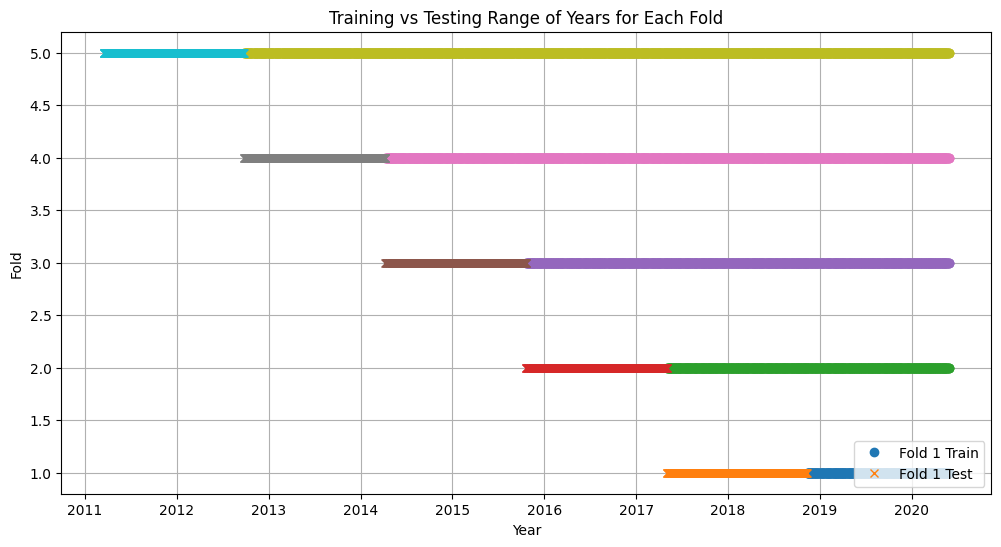

In [18]:
# Plot training vs testing years
plt.figure(figsize=(12, 6))

for i, (train, test) in enumerate(zip(train_years, test_years)):
    plt.plot(train, [i + 1] * len(train), 'o', label=f'Fold {i + 1} Train' if i == 0 else "")
    plt.plot(test, [i + 1] * len(test), 'x', label=f'Fold {i + 1} Test' if i == 0 else "")

plt.xlabel('Year')
plt.ylabel('Fold')
plt.title('Training vs Testing Range of Years for Each Fold')
plt.legend(loc='lower right')
plt.grid()
plt.show()



Fold 1 Confusion Matrix:
[[226   0]
 [ 64  96]]


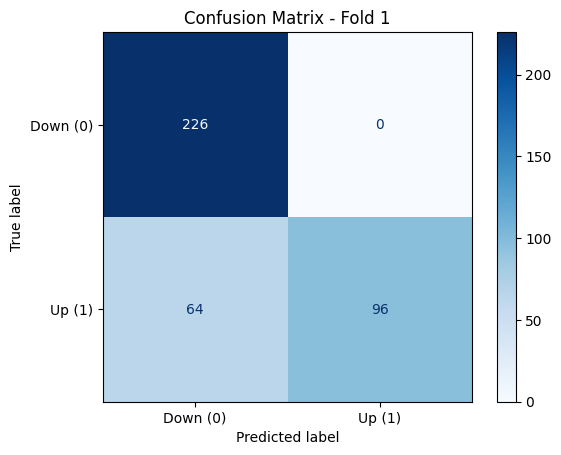

Fold 1 Accuracy: 0.83
--------------------------------------------------

Fold 2 Confusion Matrix:
[[221   3]
 [125  37]]


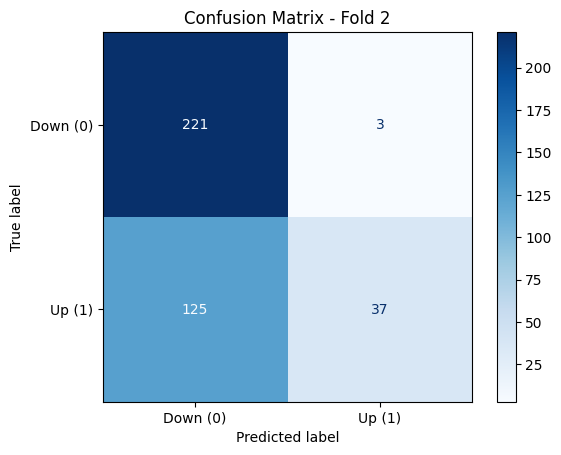

Fold 2 Accuracy: 0.67
--------------------------------------------------

Fold 3 Confusion Matrix:
[[212  22]
 [ 59  93]]


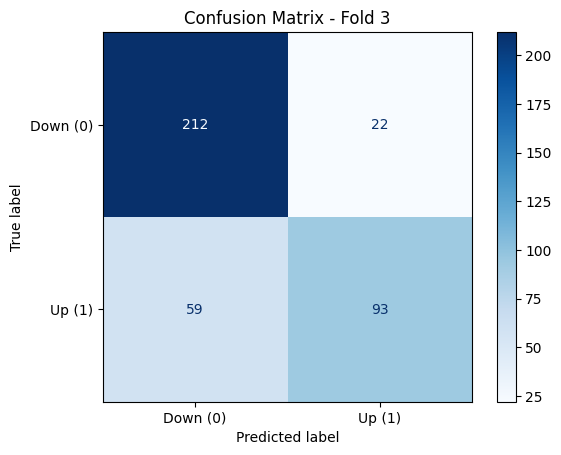

Fold 3 Accuracy: 0.79
--------------------------------------------------

Fold 4 Confusion Matrix:
[[209   8]
 [ 97  72]]


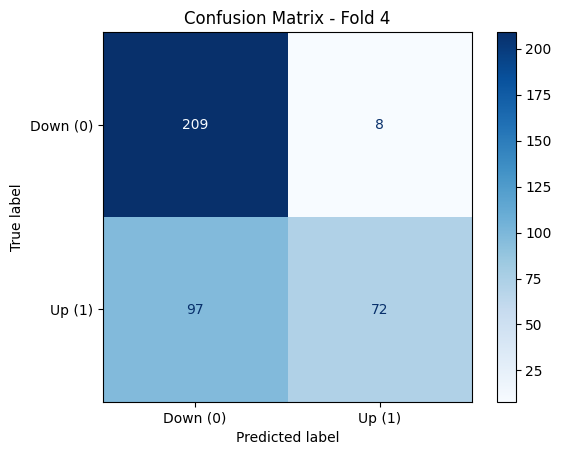

Fold 4 Accuracy: 0.73
--------------------------------------------------

Fold 5 Confusion Matrix:
[[103 109]
 [ 27 147]]


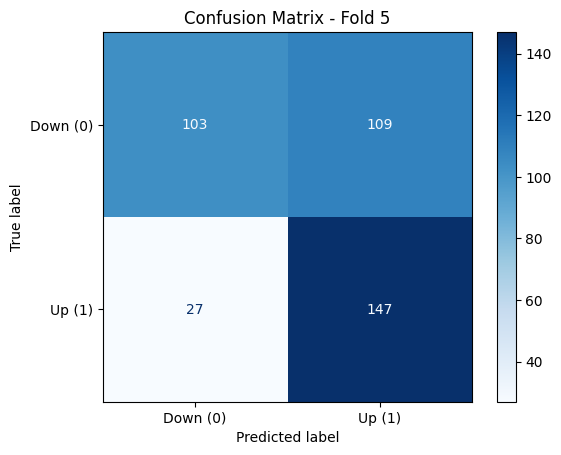

Fold 5 Accuracy: 0.65
--------------------------------------------------

Average Metrics Across Folds:
Accuracy: 0.73
Precision: 0.84
Recall: 0.54
F1-Score: 0.62
ROC-AUC: 0.87


In [19]:
# Initialize lists to store evaluation metrics
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
roc_auc_scores = []

# Perform TimeSeriesSplit
for fold, (train_index, test_index) in enumerate(tss.split(X)):
    # Split data into training and testing sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Initialize and train the Logistic Regression model
    model = LogisticRegression(random_state=42)
    model.fit(X_train_scaled, y_train)

    # Make predictions
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)

    # Append metrics for each fold
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    roc_auc_scores.append(roc_auc)

    # Print confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f"\nFold {fold + 1} Confusion Matrix:")
    print(cm)

    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Down (0)", "Up (1)"])
    disp.plot(cmap="Blues")
    disp.ax_.set_title(f"Confusion Matrix - Fold {fold + 1}")
    plt.show()

    # Print accuracy for the fold
    print(f"Fold {fold + 1} Accuracy: {accuracy:.2f}")
    print("-" * 50)

# Print average metrics
print("\nAverage Metrics Across Folds:")
print(f"Accuracy: {sum(accuracy_scores) / len(accuracy_scores):.2f}")
print(f"Precision: {sum(precision_scores) / len(precision_scores):.2f}")
print(f"Recall: {sum(recall_scores) / len(recall_scores):.2f}")
print(f"F1-Score: {sum(f1_scores) / len(f1_scores):.2f}")
print(f"ROC-AUC: {sum(roc_auc_scores) / len(roc_auc_scores):.2f}")


Fold 1 - Balanced Class Distribution:
Movement
0    152
1    152
Name: count, dtype: int64
--------------------------------------------------

Fold 1 Confusion Matrix:
[[165  61]
 [  4 156]]


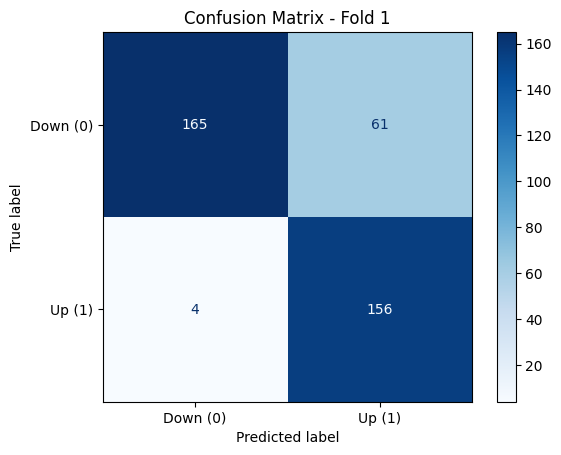

Fold 1 Accuracy: 0.83
--------------------------------------------------
Fold 2 - Balanced Class Distribution:
Movement
0    312
1    312
Name: count, dtype: int64
--------------------------------------------------

Fold 2 Confusion Matrix:
[[220   4]
 [116  46]]


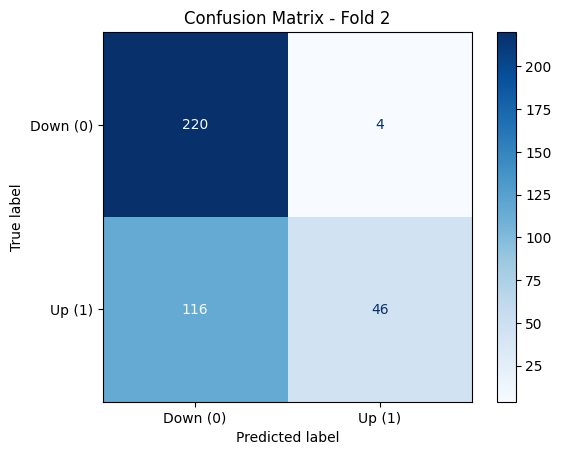

Fold 2 Accuracy: 0.69
--------------------------------------------------
Fold 3 - Balanced Class Distribution:
Movement
0    474
1    474
Name: count, dtype: int64
--------------------------------------------------

Fold 3 Confusion Matrix:
[[128 106]
 [ 12 140]]


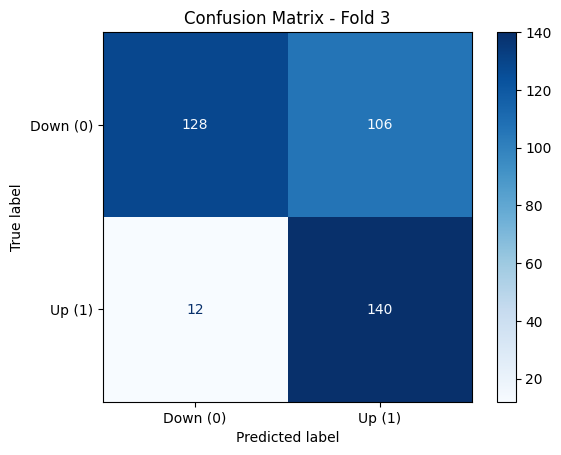

Fold 3 Accuracy: 0.69
--------------------------------------------------
Fold 4 - Balanced Class Distribution:
Movement
0    626
1    626
Name: count, dtype: int64
--------------------------------------------------

Fold 4 Confusion Matrix:
[[132  85]
 [ 26 143]]


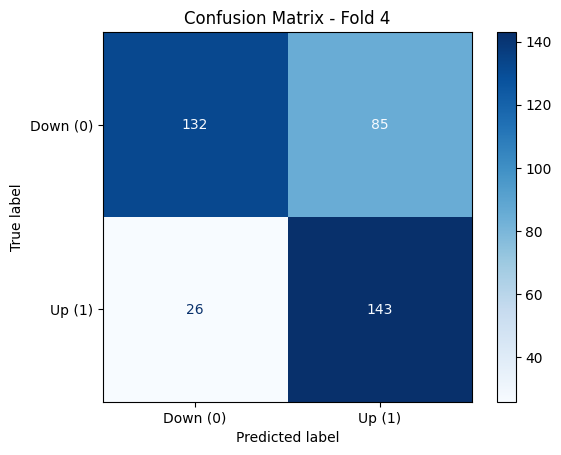

Fold 4 Accuracy: 0.71
--------------------------------------------------
Fold 5 - Balanced Class Distribution:
Movement
0    795
1    795
Name: count, dtype: int64
--------------------------------------------------

Fold 5 Confusion Matrix:
[[ 21 191]
 [  1 173]]


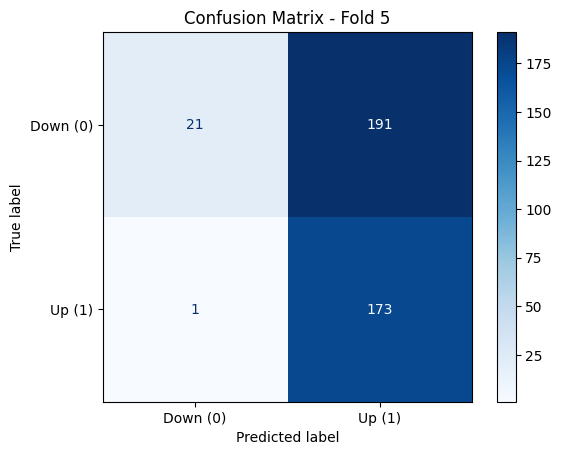

Fold 5 Accuracy: 0.50
--------------------------------------------------

Average Metrics Across Folds (Balanced Data):
Accuracy: 0.69
Precision: 0.66
Recall: 0.80
F1-Score: 0.67
ROC-AUC: 0.85


In [20]:
# Initialize SMOTE for balancing the dataset
undersampler = RandomUnderSampler(random_state=42)

# Initialize lists to store evaluation metrics
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
roc_auc_scores = []

# Perform TimeSeriesSplit
for fold, (train_index, test_index) in enumerate(tss.split(X)):
    # Split data into training and testing sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Balance the training data
    X_train_balanced, y_train_balanced = undersampler.fit_resample(X_train, y_train)

    # Print class distribution for the balanced training data
    print(f"Fold {fold + 1} - Balanced Class Distribution:")
    print(y_train_balanced.value_counts())
    print("-" * 50)

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_balanced)
    X_test_scaled = scaler.transform(X_test)

    # Initialize and train the Logistic Regression model
    model = LogisticRegression(random_state=42)
    model.fit(X_train_scaled, y_train_balanced)

    # Make predictions
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)

    # Append metrics for each fold
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    roc_auc_scores.append(roc_auc)

    # Print confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f"\nFold {fold + 1} Confusion Matrix:")
    print(cm)

    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Down (0)", "Up (1)"])
    disp.plot(cmap="Blues")
    disp.ax_.set_title(f"Confusion Matrix - Fold {fold + 1}")
    plt.show()

    # Print accuracy for the fold
    print(f"Fold {fold + 1} Accuracy: {accuracy:.2f}")
    print("-" * 50)


# Print average metrics
print("\nAverage Metrics Across Folds (Balanced Data):")
print(f"Accuracy: {sum(accuracy_scores) / len(accuracy_scores):.2f}")
print(f"Precision: {sum(precision_scores) / len(precision_scores):.2f}")
print(f"Recall: {sum(recall_scores) / len(recall_scores):.2f}")
print(f"F1-Score: {sum(f1_scores) / len(f1_scores):.2f}")
print(f"ROC-AUC: {sum(roc_auc_scores) / len(roc_auc_scores):.2f}")


In [21]:
data.to_csv('/content/drive/My Drive/nlp/dataset_final/daily_news/qqq/QQQ_numerical_LR.csv')